In [47]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import csv
from tabulate import tabulate
from collections import defaultdict
from itertools import combinations
from threading import Thread
from numba import jit
from xgboost import XGBClassifier as XGB
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.tree import ExtraTreeClassifier as ExtraTree
from sklearn.ensemble import ExtraTreesClassifier as ExtraTrees
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import RidgeClassifier as Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from Audio_Sentiment_Analysis.utils.Configuration import Configuration

In [32]:
EXTRACTED_FEATURES_FILE = 'extracted_features_ent05.csv'
SCALED_FEATURES = 'scaled_features.csv'
CONFIG_FILE = f"{os.path.abspath('./../../')}/Audio_Sentiment_Analysis/data/config.json"
config = Configuration.load_json(CONFIG_FILE)
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [33]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(df.shape)
df = df.sort_values(['Subject', 'Emotion', 'Gender'], ascending = (True, True, True))
df = df.set_index('Subject')
df.head()

(1287, 71)


,File,Gender,Emotion,Emotion_Id,spikes_mel_spect,mean_mel_spect,min_mel_spect,max_mel_spect,var_mel_spect,std_mel_spect,spikes_chroma_stft,mean_chroma_stft,var_chroma_stft,std_chroma_stft,spikes_rms,mean_rms,max_rms,var_rms,std_rms,spikes_spec_cent,mean_spec_cent,min_spec_cent,max_spec_cent,var_spec_cent,std_spec_cent,spikes_spec_bw,mean_spec_bw,min_spec_bw,max_spec_bw,var_spec_bw,std_spec_bw,spikes_spec_rolloff,mean_spec_rolloff,min_spec_rolloff,max_spec_rolloff,var_spec_rolloff,std_spec_rolloff,spikes_spec_cont,mean_spec_cont,min_spec_cont,max_spec_cont,var_spec_cont,std_spec_cont,spikes_zcr,mean_zcr,min_zcr,max_zcr,var_zcr,std_zcr,sum_zcr,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
Subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,s1_an_1,m,anger,0,1443,5.470246,4.425599e-10,2683.060303,2835.492676,53.249344,750,0.402497,0.097249,0.311847,83,0.129479,0.340202,0.007750,0.088035,58,1814.026368,812.639867,4084.492417,437557.880517,661.481580,69,1834.495092,1104.902824,2673.005407,154644.510964,393.248663,71,3811.157227,904.394531,6707.592773,2.016124e+06,1419.902686,344,22.718679,7.062807,51.588313,82.005473,9.055687,65,0.093647,0.026855,0.269531,0.001995,0.044666,13.766113,-171.056549,115.938042,-28.566433,21.314878,-26.507704,10.144446,-22.394417,-6.446075,-20.058737,-9.614692,-15.731797,-8.805966,-2.915169,-12.226694,-5.387331,-4.913488,-9.523164,-1.791623,-3.507744,0.083974
1,s1_an_2,m,anger,0,1297,4.795432,3.266728e-10,1598.459473,1602.659546,40.033230,578,0.369817,0.094729,0.307780,64,0.122001,0.275363,0.007222,0.084985,46,1813.929245,1077.773997,4802.078139,517671.206155,719.493715,46,1772.517500,1209.119846,2615.316302,160594.827485,400.742845,48,3602.609923,1711.889648,7288.989258,2.051509e+06,1432.308845,304,22.243432,5.936659,48.160193,77.321635,8.793272,42,0.095251,0.034668,0.402832,0.004444,0.066661,11.715820,-187.978119,114.721764,-41.258282,22.174334,-12.715221,11.881121,-22.636301,-9.284859,-23.113136,-7.031469,-15.980973,-11.601790,-5.727098,-6.378960,-7.155036,-7.385511,-8.306025,4.346861,-6.595266,-2.742662
1,s1_an_5,m,anger,0,909,6.344573,4.247520e-10,4932.327637,6391.681152,79.947990,536,0.312011,0.098784,0.314300,61,0.140534,0.410695,0.008144,0.090243,50,1577.596083,731.779647,3118.561755,152720.583570,390.794810,47,1621.112545,998.916801,2391.307207,100143.189503,316.454088,62,3149.887457,775.195312,5910.864258,1.215127e+06,1102.328088,304,23.661057,6.420219,50.013285,71.860833,8.477077,52,0.072095,0.033203,0.153809,0.000541,0.023251,8.867676,-180.083939,119.054886,-42.182270,26.999893,-6.590928,8.636041,-17.951387,-20.642817,-24.792250,-4.610571,-18.438587,-11.906024,-3.913879,-11.295942,-3.214928,-6.571509,-0.506520,1.930403,-6.855784,-2.346526
1,s1_an_4,m,anger,0,898,7.300478,3.510179e-10,3062.532715,4610.922363,67.903770,417,0.272837,0.095383,0.308841,58,0.155781,0.308454,0.007771,0.088151,41,1578.663080,989.554541,3072.898800,113822.283518,337.375582,37,1679.770568,1277.610555,2577.918929,89344.835302,298.906064,39,3222.159447,1539.624023,6180.029297,9.498801e+05,974.617910,238,23.566948,8.367288,49.570257,78.338294,8.850892,44,0.068912,0.036621,0.134277,0.000354,0.018807,7.304688,-166.445877,122.271973,-42.199047,19.365204,-21.122906,8.933196,-21.792807,-10.018277,-22.990005,-9.038509,-19.050367,-9.762544,0.404813,-14.561901,-6.730536,-4.809193,-5.546733,2.948940,-6.117626,-3.003350
1,s1_an_3,m,anger,0,1392,3.334237,3.032449e-10,689.850098,542.464478,23.290867,603,0.402758,0.097614,0.312432,57,0.093039,0.258287,0.007551,0.086896,61,1699.189320,1154.867212,2519.734104,118628.430190,344.424782,51,1764.541591,1131.241853,2699.423772,195473.567039,442.123927,57,3558.226103,1604.223633,5770.898438,1.733753e+06,1316.720683,301,21.846660,6.884981,48.784060,66.028699,8.125805,58,0.089708,0.041016,0.129395,0.000406,0.020160,10.675293,-241.878052,123.269180,-36.750164,15.108225,-17.863935,12.1

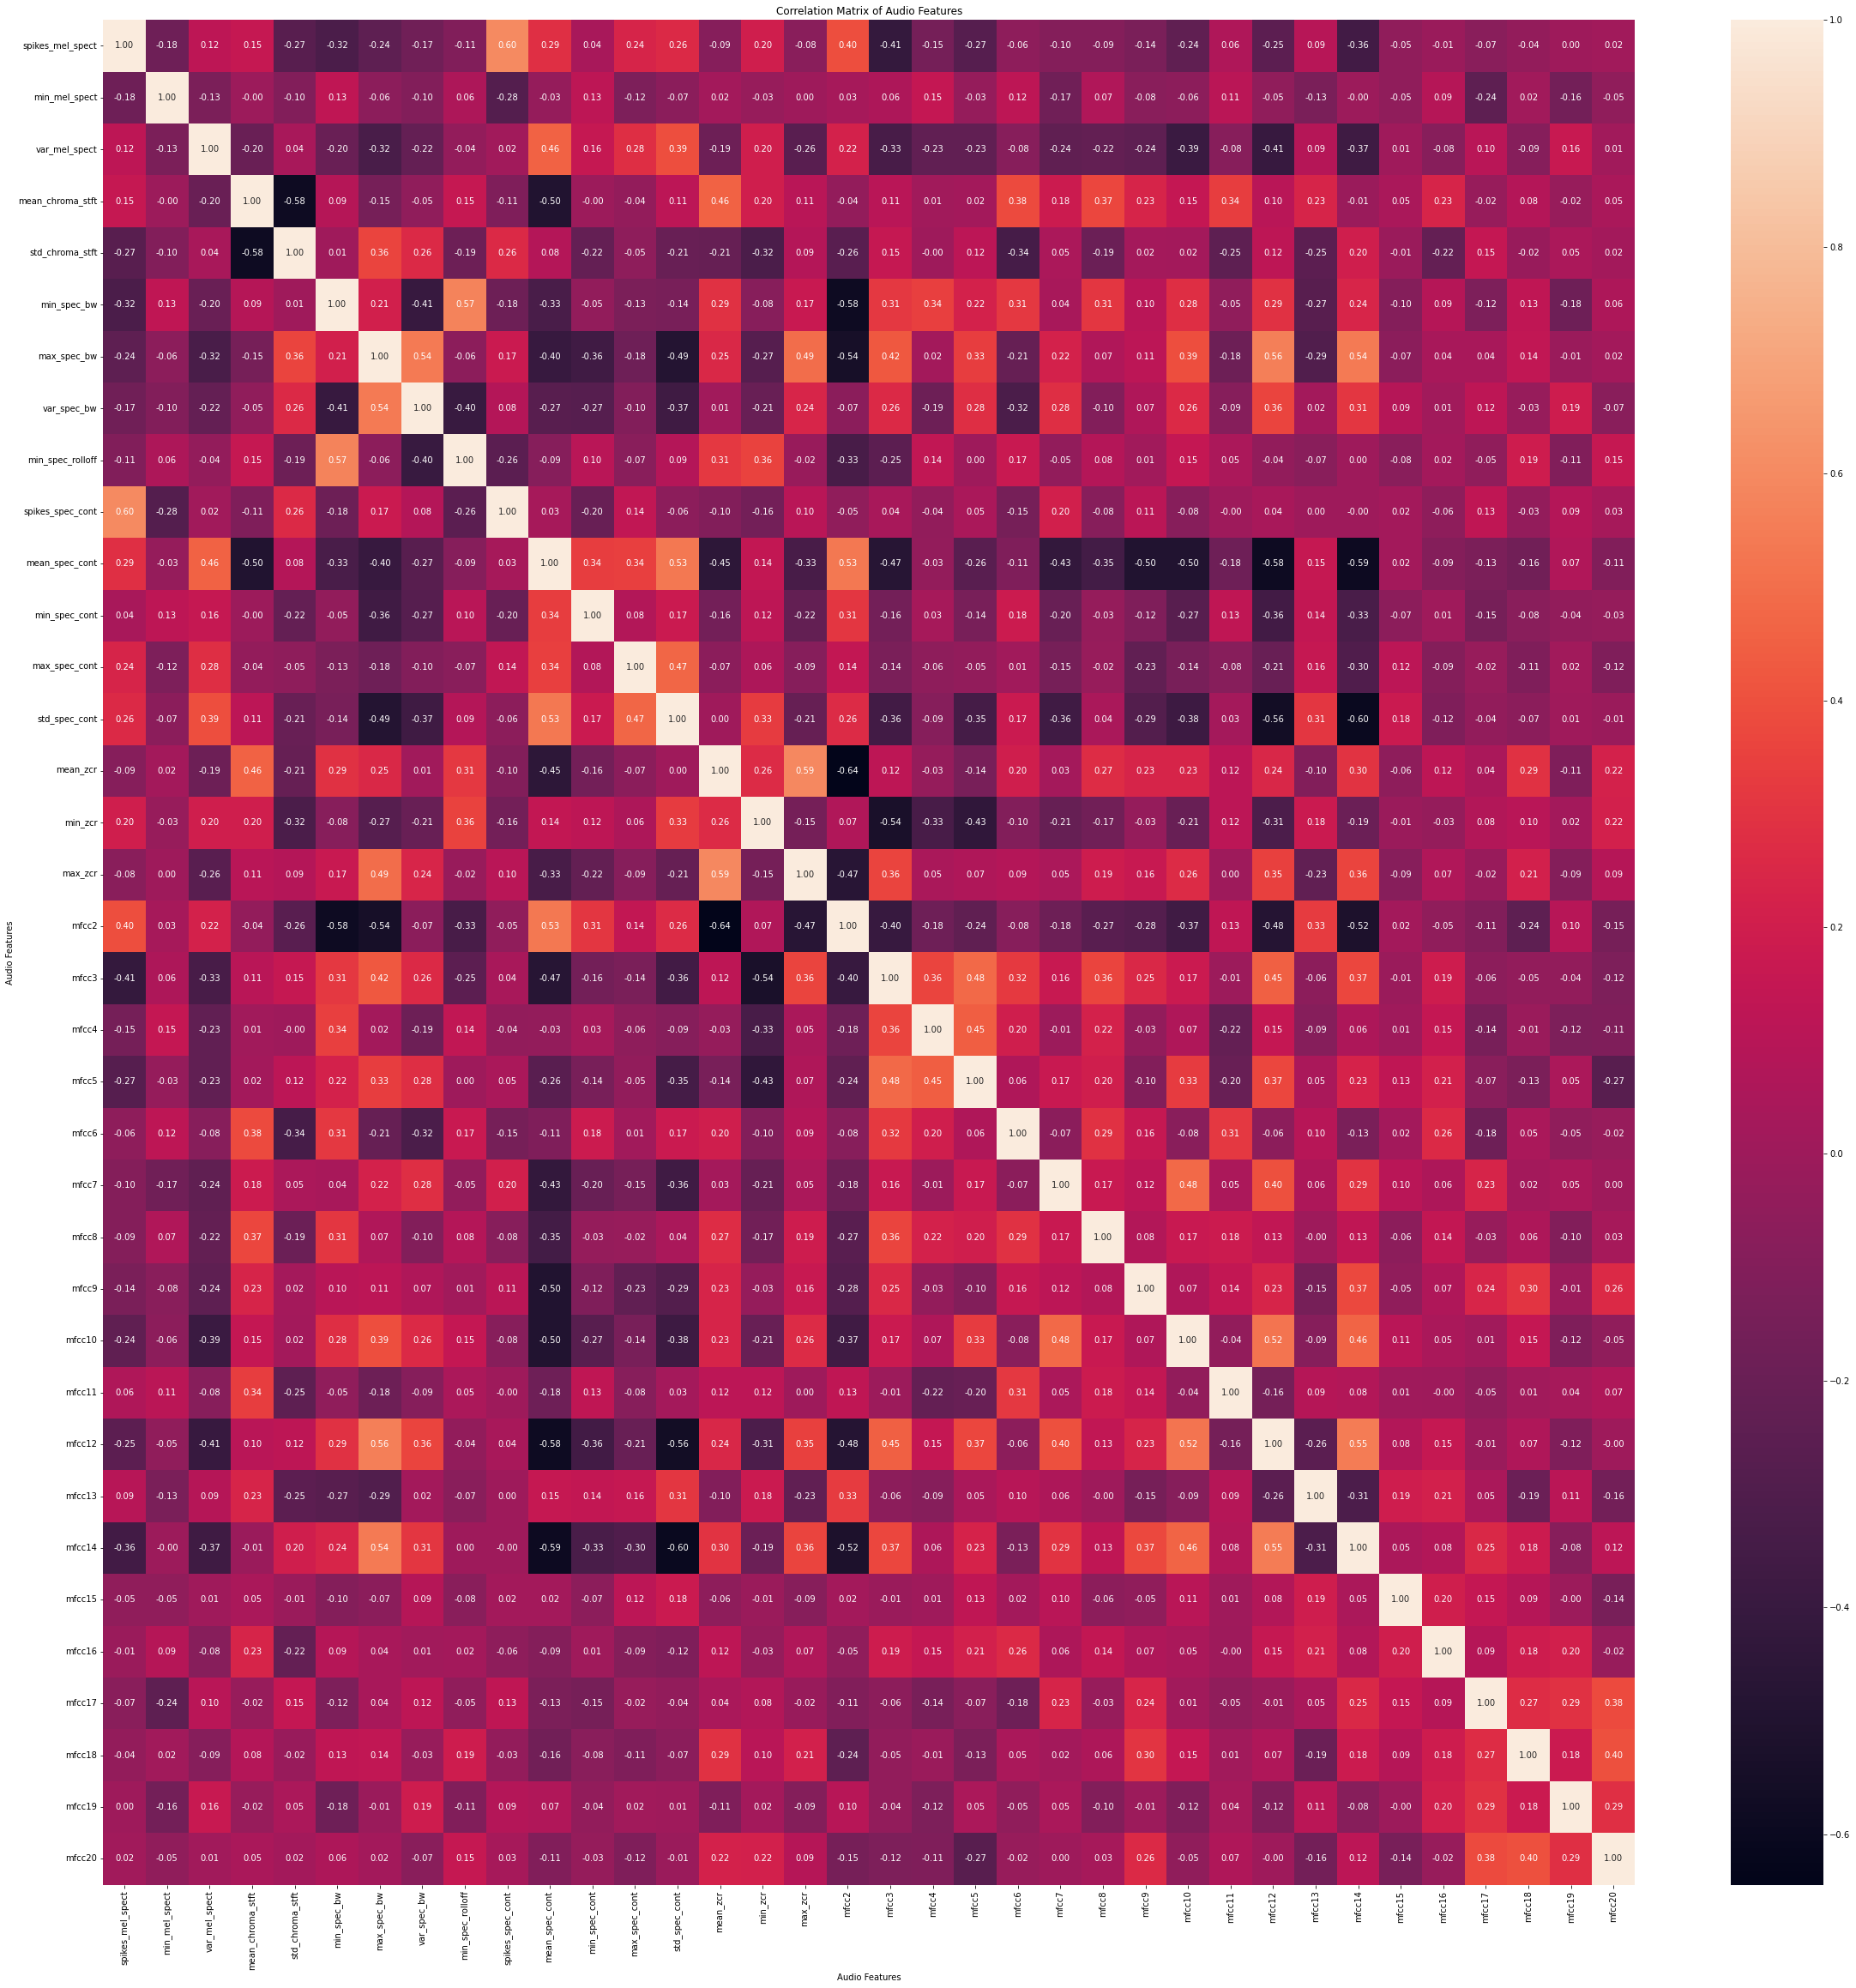

In [60]:
plt.figure(figsize=(40,40))
df_corr = df.iloc[:,4:].corr()
sns.heatmap(df_corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [35]:
def hight_corr_feat_elimination(df_corr):
    corr_pairs = df_corr.unstack()
    # order pairs of features with highest correlations
    strong_pairs = []
    for pair in corr_pairs.items():
        if pair[0][0] != pair[0][1] and abs(pair[1]) > 0.7\
            and ((pair[0][1], pair[0][0]), pair[1]) not in strong_pairs:
            strong_pairs.append(((pair[0][0], pair[0][1]), pair[1]))
    strong_pairs.sort(reverse=True, key=lambda x: abs(x[1]))

    eliminated_feats = set()

    for pair in strong_pairs:
        corr = pair[1]
        f1 = pair[0][0]
        f2 = pair[0][1]

        if corr > 0.7 and \
            f1 not in eliminated_feats and \
            f2 not in eliminated_feats:
            mean_corr_f1 = np.mean(abs(df_corr[f1].values))
            mean_corr_f2 = np.mean(abs(df_corr[f2].values))

            eliminated_feats.add(f1 if mean_corr_f1 > mean_corr_f2 else f2)

    return eliminated_feats

In [36]:
eliminated_feats = hight_corr_feat_elimination(df_corr)
print(len(eliminated_feats))
print(eliminated_feats)

30
{'spikes_zcr', 'var_chroma_stft', 'var_spec_cont', 'max_rms', 'mfcc1', 'std_zcr', 'mean_spec_cent', 'std_spec_bw', 'var_rms', 'mean_rms', 'mean_spec_rolloff', 'spikes_chroma_stft', 'max_mel_spect', 'spikes_rms', 'spikes_spec_bw', 'var_spec_rolloff', 'max_spec_cent', 'max_spec_rolloff', 'min_spec_cent', 'var_zcr', 'std_spec_cent', 'spikes_spec_cent', 'sum_zcr', 'mean_spec_bw', 'mean_mel_spect', 'var_spec_cent', 'std_spec_rolloff', 'std_rms', 'spikes_spec_rolloff', 'std_mel_spect'}


In [37]:
[df.drop(feat, inplace=True, axis=1) for feat in eliminated_feats]
num_features = len(df.columns)-4
print(f"Number of features after high correlation elimination: {num_features}")

Number of features after high correlation elimination: 36


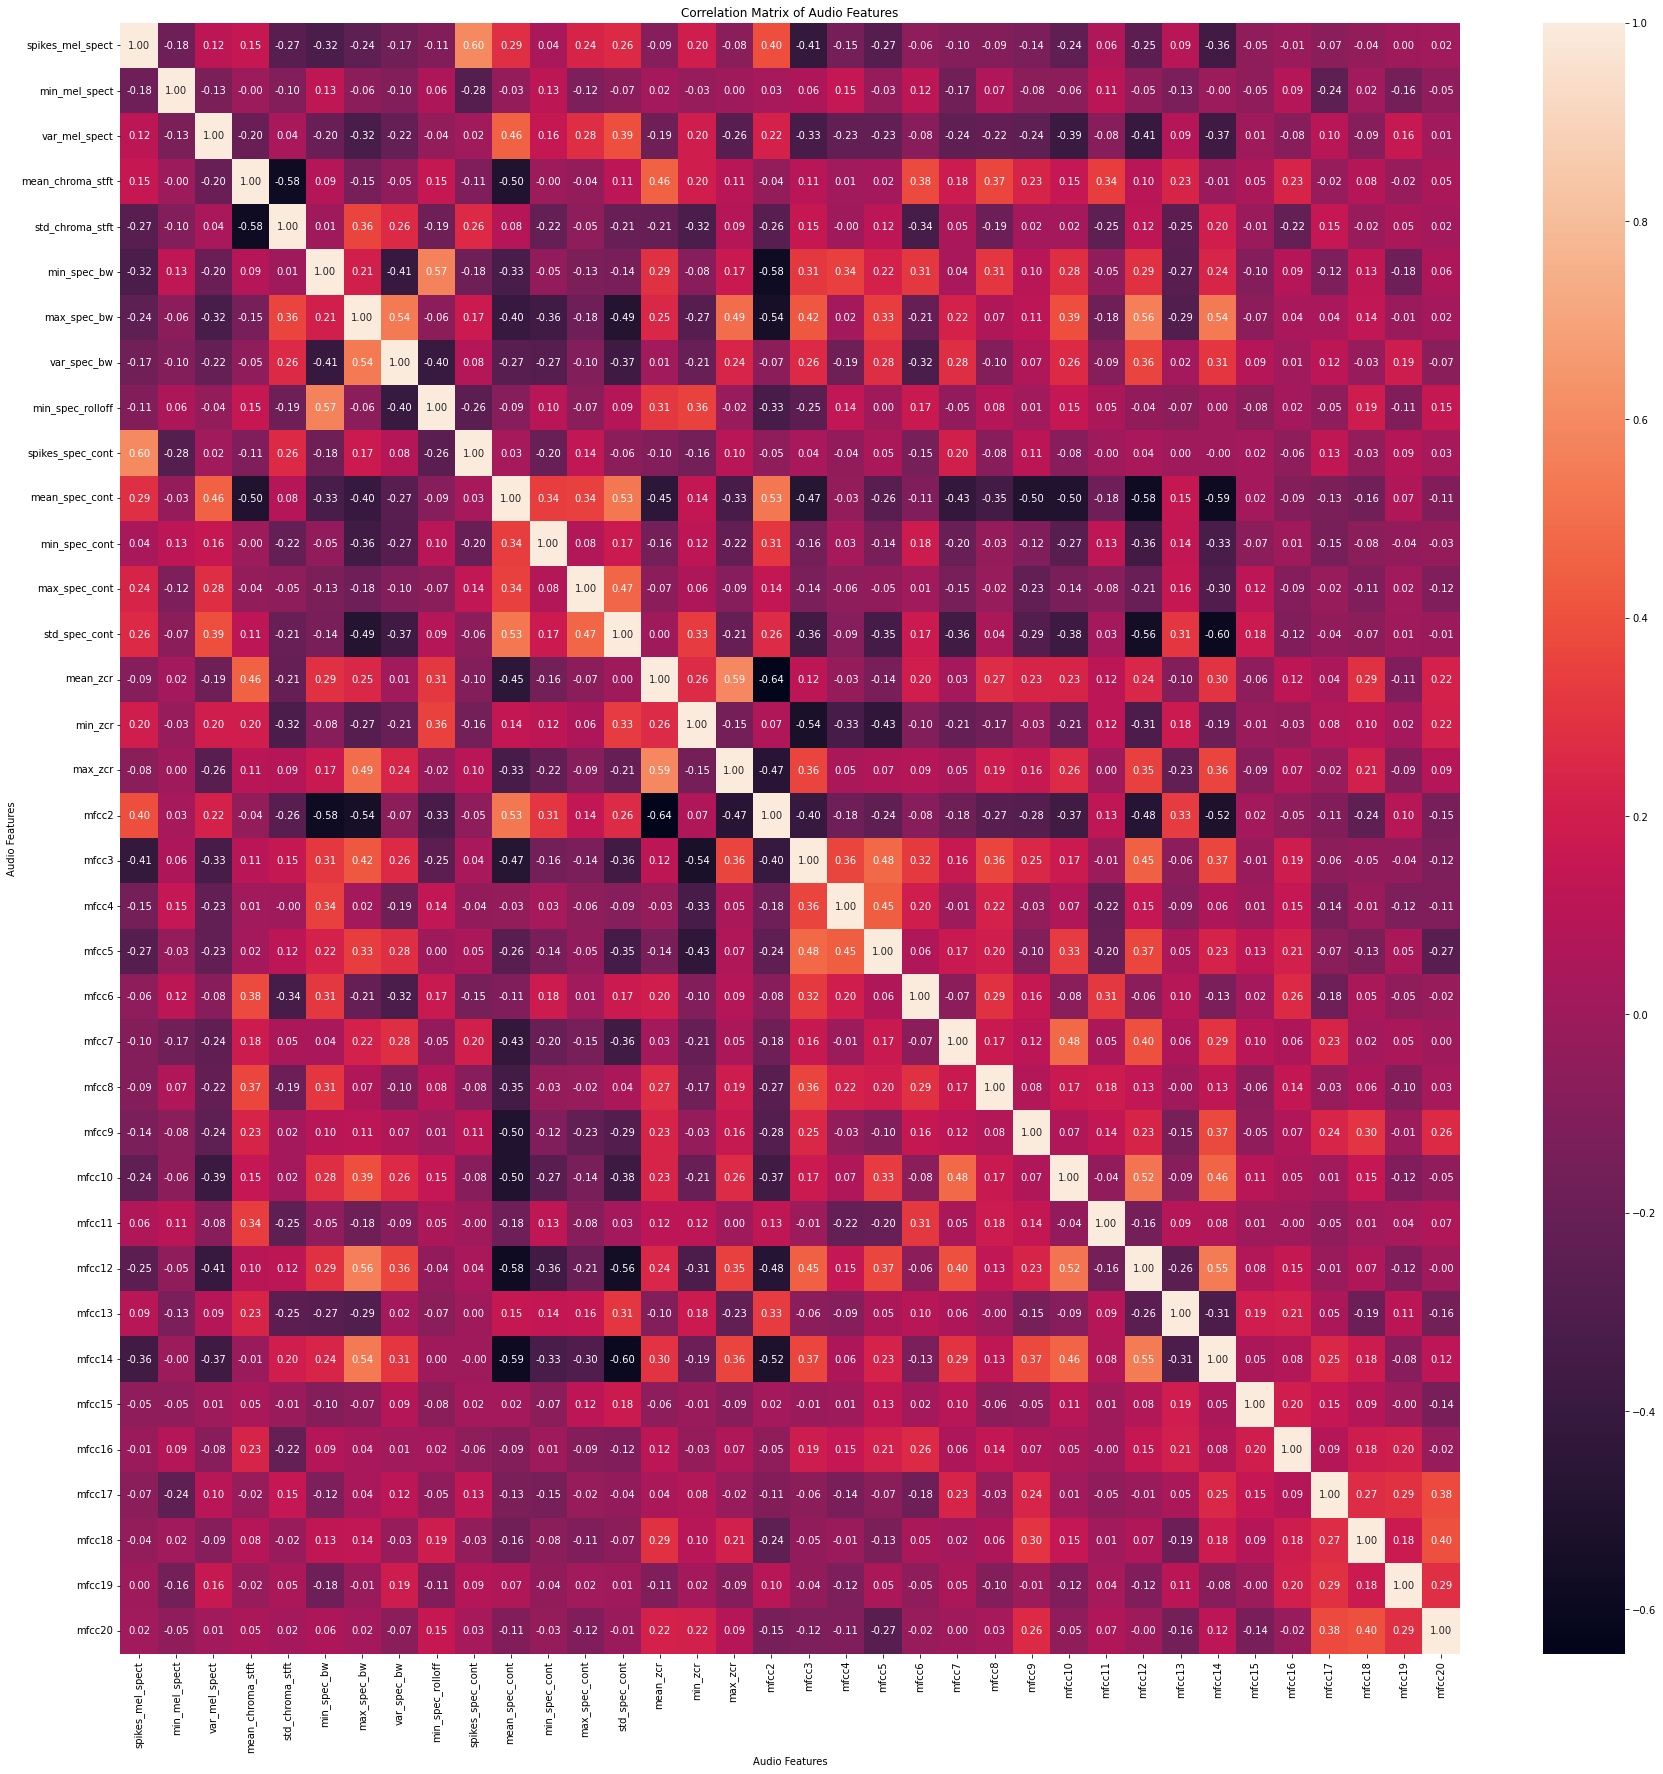

In [61]:
plt.figure(figsize=(30,30))
df_corr = df.iloc[:,4:].corr()
sns.heatmap(df_corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [39]:
data = df.iloc[:,4:]
features = df.columns.values[4:]
labels = df["Emotion_Id"].values

## Compare Scores of Classifiers

In [40]:
def compare_clfs(clfs, data, labels):
    clfs_scores = defaultdict(dict)
    
    for clf in clfs:
        scores = cross_val_score(clf, data, labels, cv=5)
        
        # scores for each fold
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        clfs_scores[clf.__class__.__name__.split("(")[0]] = (mean_score, std_score)
    
    return clfs_scores

In [41]:
%%capture
clfs = [
    DecisionTree(random_state=1, max_features=None),
    ExtraTree(random_state=1, max_features=None),
    RandomForest(random_state=1, max_features=None),
    ExtraTrees(random_state=1, max_features=None),
    XGB(random_state=1, objective="multi:softprob"),
    Ridge(random_state=1)
]

clfs_scores = compare_clfs(clfs, data, labels)

In [42]:
print(f"Classifiers Ordered by Highest Mean Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][0], reverse=True)
    ), orient="index", columns=["Mean", "Std"]), headers = 'keys'
))

print(f"\nClassifiers Ordered by Lowest Standard Deviation Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][1])
    ), orient="index", columns=["Mean", "Std"]), headers = 'keys'
))

Classifiers Ordered by Highest Mean Accuracy:
                            Mean        Std
----------------------  --------  ---------
ExtraTreesClassifier    0.473185  0.0227786
XGBClassifier           0.459195  0.0425803
RidgeClassifier         0.456037  0.0346476
RandomForestClassifier  0.44833   0.0181348
DecisionTreeClassifier  0.306105  0.0360249
ExtraTreeClassifier     0.262637  0.0310688

Classifiers Ordered by Lowest Standard Deviation Accuracy:
                            Mean        Std
----------------------  --------  ---------
RandomForestClassifier  0.44833   0.0181348
ExtraTreesClassifier    0.473185  0.0227786
ExtraTreeClassifier     0.262637  0.0310688
RidgeClassifier         0.456037  0.0346476
DecisionTreeClassifier  0.306105  0.0360249
XGBClassifier           0.459195  0.0425803


## Confusion Matrix for Predictions

In [54]:
clf = RandomForest(random_state=1, max_features=None)
y_pred = cross_val_predict(clf, data, labels, cv=5)
cm = metrics.confusion_matrix(labels, y_pred)

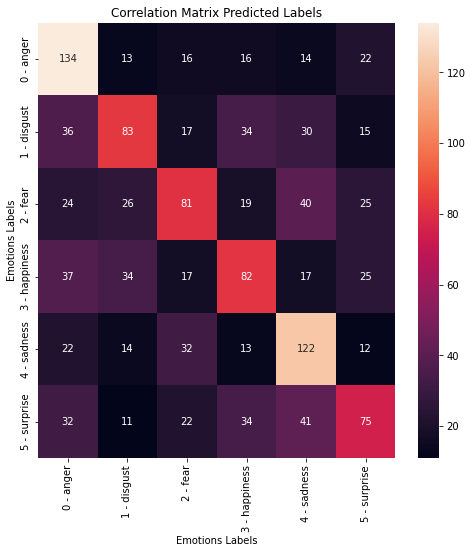

In [69]:
emotions_number = [
    '0 - anger',
    '1 - disgust',
    '2 - fear',
    '3 - happiness',
    '4 - sadness',
    '5 - surprise'
]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=emotions_number, yticklabels=emotions_number)
plt.title("Correlation Matrix Predicted Labels")
plt.xlabel("Emotions Labels")
plt.ylabel("Emotions Labels")
plt.show()

## Feature Elimination Without Propagation

In [43]:
@jit
def drop_feats(data, labels, comb_thread, feature_results):
    for drop_features in comb_thread:
        X_train = data.copy()

        feats = ()
        # drop each feature on the combination
        for i, feature in enumerate(drop_features):
            feats += (feature,)

            X_train.drop(feature, inplace=True, axis=1)

            if feats in feature_results[i+1]:
                continue

            clf = RandomForest(random_state=1, max_features=None)
            scores = cross_val_score(clf, X_train, labels, cv=5)

            # mean score across all folds
            mean_score = np.mean(scores)
            std_score = np.std(scores)

            feature_results[i+1][feats] = (mean_score, std_score)

@jit
def feature_elim(data, features, labels, n_features=1, n_threads=8):
    feature_results = defaultdict(dict)

    comb = list(combinations(features, n_features))
    comb_per_thread = int(math.ceil(len(comb) / n_threads))
    threads = []
    for i in range(n_threads):
        comb_thread = comb[i*comb_per_thread:comb_per_thread*(i+1)+1]
        t = Thread(target=drop_feats, args=(data, labels, comb_thread, feature_results))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()
    
    return feature_results

In [45]:
%%capture
feature_results = feature_elim(data, features, labels, 1)

In [46]:
data_results = {}
for n_feat, results in feature_results.items():
    dict_res = dict(sorted(results.items(), key=lambda item: item[1], reverse=True)[:20])
    data_results.update(dict_res)
data_results = pd.DataFrame().from_dict(data_results, orient="index", columns=["Mean Acc", "Std Acc"])
data_results

,Mean Acc,Std Acc
"(mfcc14,)",0.461539,0.024556
"(mfcc15,)",0.460773,0.021155
"(mfcc16,)",0.459231,0.026970
"(mfcc18,)",0.455337,0.018298
"(spikes_spec_cont,)",0.455319,0.020531
"(min_spec_bw,)",0.453003,0.026154
"(min_mel_spect,)",0.453000,0.019280
"(mfcc9,)",0.452982,0.017531
"(mfcc12,)",0.452228,0.025571
"(mfcc17,)",0.452222,0.027192


## Feature Elimination with Backward Propagation

- Less 1 feature

In [ ]:
sfs1 = sfs(RandomForest(random_state=1, max_features=None), k_features=num_features-1, forward=False, cv=5, n_jobs=8)
sfs1 = sfs1.fit(data, labels)
print(sfs1.k_score_)
feat_names = set(sfs1.k_feature_names_)
left_out_features = [feat for feat in features if feat not in feat_names]
print(left_out_features)

0.46153892558742804
['mfcc14']


- For All Features

In [ ]:
feat_elim = {}
df_train = data.copy()
for i in range(num_features-1, 0, -1):
    sfs1 = sfs(RandomForest(random_state=1, max_features=None), k_features=i, forward=False, cv=5, n_jobs=8)
    sfs1 = sfs1.fit(df_train, labels)
    feat_names = set(sfs1.k_feature_names_)
    eliminated_f = [feat for feat in features if feat not in feat_names and feat not in feat_elim][0]
    feat_elim[eliminated_f] = sfs1.k_score_
    df_train.drop(eliminated_f, inplace=True, axis=1)

In [ ]:
feat_elim_df = pd.DataFrame().from_dict(feat_elim, orient="index", columns=["Accuracy"])
print(tabulate(feat_elim_df.iloc[:10,:], headers = 'keys'))

                    Accuracy
----------------  ----------
mfcc14              0.461539
mean_chroma_stft    0.459222
min_spec_bw         0.466992
min_spec_rolloff    0.468531
mfcc16              0.464649
min_mel_spect       0.473969
max_spec_cont       0.477878
mfcc7               0.476307
mfcc18              0.471616
mfcc19              0.474738


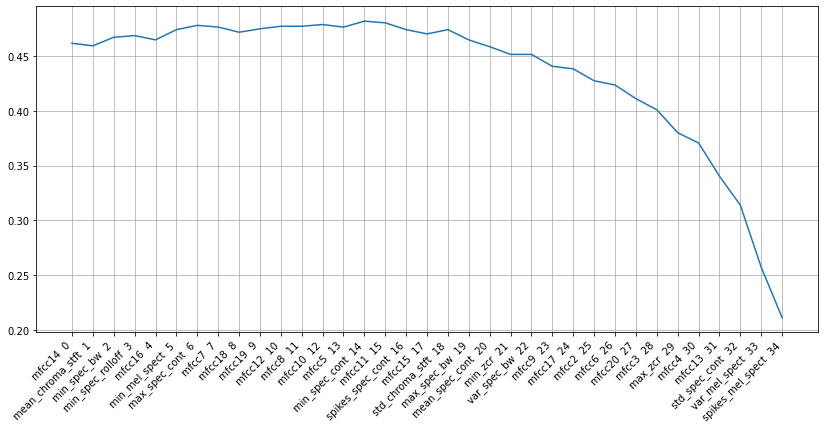

In [ ]:
fig = plt.figure(figsize=(14,6))
ax = plt.axes()
plt.grid()
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
x_labels = [f"{feat_elim_df.index.values[i]}  {i}" for i in range(len(feat_elim_df.index.values))]
ax.plot(x_labels, feat_elim_df['Accuracy'].values)